In [1]:
from Bio import PDB
from Bio.PDB.Polypeptide import PPBuilder
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
import os

In [2]:
# Get and parse all pdb files in a folder

def parsePdbFiles(dir_path):
    structures = []
    
    files = os.listdir(dir_path)
    pdb_files = [(f, os.path.join(dir_path, f)) for f in files if f.endswith(".pdb")]
    
    for pdb, pdb_path in pdb_files:
        parser = PDB.PDBParser()
        structure = parser.get_structure(pdb, pdb_path) 
        structures.append(structure)
        
    return structures

In [3]:
structures = parsePdbFiles("pdb_sample")
structures

/home/apaydin/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4909.
  PDBConstructionWarning)
/home/apaydin/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4957.
  PDBConstructionWarning)
/home/apaydin/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5005.
  PDBConstructionWarning)
/home/apaydin/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5184.
  PDBConstructionWarning)
/home/apaydin/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5492.
  PDBConstructionWarning)
/home/apaydin/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBCon

[<Structure id=1a4i.pdb>,
 <Structure id=1gji.pdb>,
 <Structure id=1a3q.pdb>,
 <Structure id=1b0a.pdb>,
 <Structure id=1n71.pdb>,
 <Structure id=1q2y.pdb>,
 <Structure id=1a02.pdb>,
 <Structure id=1m4d.pdb>,
 <Structure id=1ee9.pdb>]

### Aminoacid pair distance Matrix

In [4]:
def AminoacidPairDistanceMatrix(structure):
    aa_vectors = {} # aminoacid vector dictionary {aa_id: aa_carbon_coordinate} 

    aa_id = 0 # aminoacid id
    for model in structure:
        for chain in model:
          if chain.id == protein_chain_dict[str(structure.id)]:
            for residue in chain:
                try:
                    coords_CA = residue['CA'].coord # x,y,z coordinates of the C-alpha atom
                    aa_vectors[aa_id] = coords_CA
                except:
                    aa_id += 1
                    continue
                aa_id += 1

    aa_distance_matrix = [] # Aminoacid pair distance matrix
    for vec in aa_vectors.values():
        dist_vec = []
        for vec_ in aa_vectors.values():
            distance = np.linalg.norm(vec-vec_)
            dist_vec.append(distance)
        aa_distance_matrix.append(dist_vec)
        
    return np.array(aa_distance_matrix)

In [5]:
protein_chain_dict = {"1m4d.pdb": "B", "1n71.pdb":"B", "1q2y.pdb":"A", "1a02.pdb":"N","1a3q.pdb":"B", "1gji.pdb": "B", "1a4i.pdb":"A", "1b0a.pdb": "A", "1ee9.pdb": "A"}

In [6]:
protein_matrix_dict = {}
for protein in structures:
    protein_matrix = AminoacidPairDistanceMatrix(protein)
    protein_matrix_dict[protein.id] = protein_matrix
    print(protein.id, protein_matrix.shape)

1a4i.pdb (285, 285)
1gji.pdb (275, 275)
1a3q.pdb (285, 285)
1b0a.pdb (287, 287)
1n71.pdb (179, 179)
1q2y.pdb (140, 140)
1a02.pdb (280, 280)
1m4d.pdb (176, 176)
1ee9.pdb (317, 317)


In [7]:
from PIL import Image
img = Image.fromarray(protein_matrix_dict["1q2y.pdb"], 'RGB')
img.save('1q2y.png')
img.show()

## Dimensionality Reduction with Autoencoders

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

/home/apaydin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_gpus())

['/device:CPU:0']


In [12]:
def StackedAutoencoderWithTiedWeights(X_train, input_size, n_hidden1, n_hidden2):
    with tf.device('/device:GPU:0'):
        n_inputs = input_size 
        n_hidden1 = n_hidden1
    n_hidden2 =  n_hidden2 # codings
    n_hidden3 = n_hidden1 
    n_outputs = n_inputs

    learning_rate = 0.01
    l2_reg = 0.001

    activation = tf.nn.elu
    regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    initializer = tf.contrib.layers.variance_scaling_initializer()

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    keep_prob = tf.placeholder(tf.float32)

    weights1_init = initializer([n_inputs, n_hidden1])
    weights2_init = initializer([n_hidden1, n_hidden2])

    weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1") 
    weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2") 
    weights3 = tf.transpose(weights2, name="weights3") # tied weights
    weights4 = tf.transpose(weights1, name="weights4") # tied weights

    biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
    biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
    biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
    biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

    hidden1 = activation(tf.matmul(X, weights1) + biases1)
    hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
    hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
    outputs = tf.matmul(hidden3, weights4) + biases4

    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    reg_loss = regularizer(weights1) + regularizer(weights2)

    loss = reconstruction_loss + reg_loss

    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    
    n_epochs = 5
    
    with tf.Session() as sess: 
        init.run() 
        for epoch in range(n_epochs):
            sess.run(training_op, feed_dict={X: X_train})

        features = hidden2.eval(feed_dict= {X: X_train})
                
    return features

In [13]:
protein_features = {}
for protein, matrix in protein_matrix_dict.items():
    X_train = [np.array(matrix).flatten()]
    input_size = len(X_train[0])
    
    features = StackedAutoencoderWithTiedWeights(X_train, input_size, 1000, 500)
    protein_features[protein] = features
    
    print(protein, matrix.shape)
    print(len(features[0]), "\n --------------------------------------------------------")

1a4i.pdb (285, 285)
500 
 --------------------------------------------------------
1gji.pdb (275, 275)
500 
 --------------------------------------------------------
1a3q.pdb (285, 285)
500 
 --------------------------------------------------------
1b0a.pdb (287, 287)
500 
 --------------------------------------------------------
1n71.pdb (179, 179)
500 
 --------------------------------------------------------
1q2y.pdb (140, 140)
500 
 --------------------------------------------------------
1a02.pdb (280, 280)
500 
 --------------------------------------------------------
1m4d.pdb (176, 176)
500 
 --------------------------------------------------------
1ee9.pdb (317, 317)
500 
 --------------------------------------------------------


In [15]:
C = ["1a4i.pdb", "1b0a.pdb", "1ee9.pdb"]
B = ["1a02.pdb","1a3q.pdb", "1gji.pdb"]
D = ["1m4d.pdb", "1n71.pdb", "1q2y.pdb"]

features = []

for f in B:
    features.append(protein_features[f][0])
for f in C:
    features.append(protein_features[f][0])
for f in D:
    features.append(protein_features[f][0])

In [16]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
features_2d

array([[ 266932.7987715 ,   17329.2583987 ],
       [ -48697.16825396,  207004.68949211],
       [ -42832.17006953,  -19101.99583996],
       [  -4835.28629582,   10941.04217857],
       [  60130.26594138,  -63907.25231987],
       [ -54685.38882788, -105270.26923879],
       [ -53678.36111908,  -14663.91523654],
       [ -57526.5870778 ,  -14687.80492589],
       [ -64808.1030688 ,  -17643.75250835]])

In [17]:
x = [f[0] for f in features_2d]
y = [f[1] for f in features_2d]

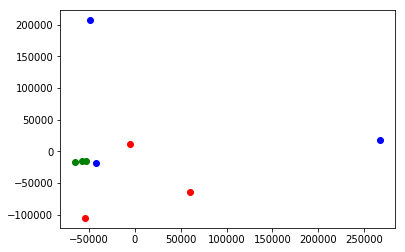

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x[:3], y[:3], 'ob')
ax.plot(x[3:6], y[3:6], 'or')
ax.plot(x[6:], y[6:], 'og')

plt.show()